Loading datasets...
BoT-IoT shape: (1150356, 16), ToN-IoT shape: (484750, 16)
BoT DDoS ratio: 0.997
ToN DDoS ratio: 0.562
Selected 8 features from source dataset:
  1. Total Backward Packets (importance: 0.0810)
  2. Total Fwd Packets (importance: 0.0968)
  3. Flow Duration (importance: 0.0982)
  4. Flow Packets/s (importance: 0.1045)
  5. Bwd IAT Mean (importance: 0.1118)
  6. Fwd IAT Mean (importance: 0.1128)
  7. Flow Bytes/s (importance: 0.1196)
  8. Flow IAT Mean (importance: 0.1198)

=== Chi-Square Feature Importance ===
               Feature  Chi_square_score  p_value
          Fwd IAT Mean      1.966645e+10      0.0
          Flow Bytes/s      1.002091e+10      0.0
          Bwd IAT Mean      9.832886e+09      0.0
        Flow Packets/s      9.818978e+08      0.0
         Flow IAT Mean      2.779386e+08      0.0
         Flow Duration      1.244292e+08      0.0
     Total Fwd Packets      9.703801e+07      0.0
Total Backward Packets      4.770278e+07      0.0
Starting comprehe

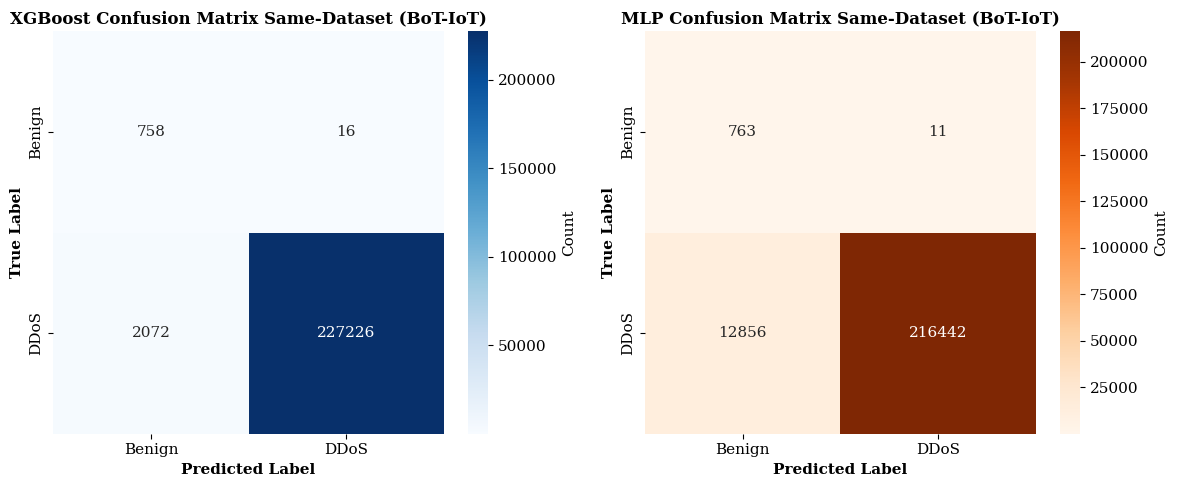

Figure saved: confusion_matrices_same-dataset_(bot-iot).png
Generating Figure 2: Same-Dataset ROC Curves (BoT-IoT)...


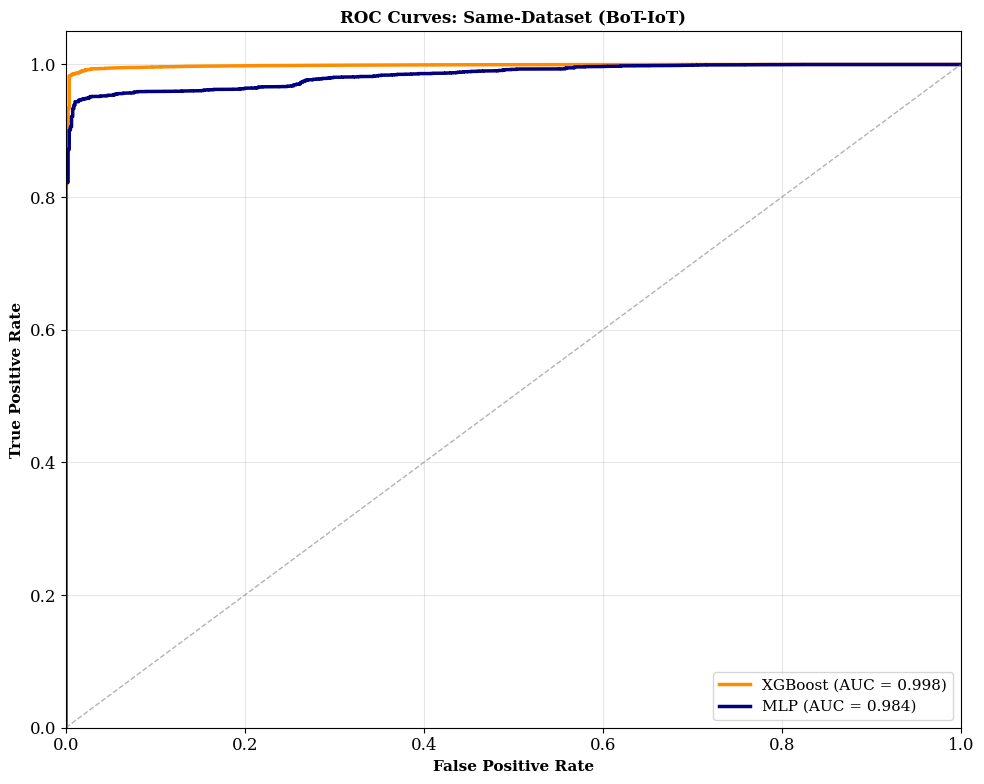

Figure saved: roc_curves_same-dataset_(bot-iot).png
Generating Figure 3: Same-Dataset Metrics Comparison (BoT-IoT)...


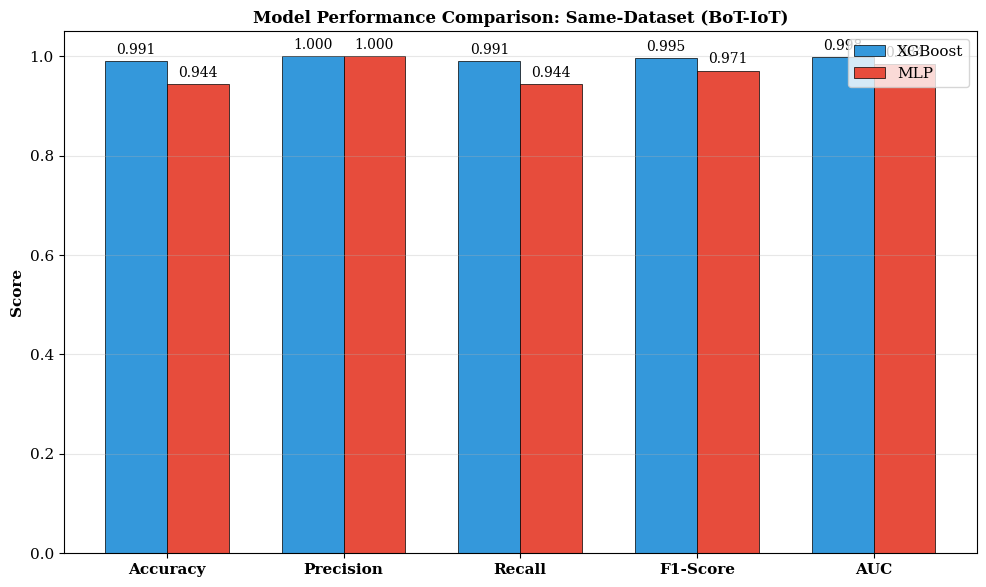

Figure saved: metrics_comparison_same-dataset_(bot-iot).png
Generating Figure 4: Cross-Dataset Confusion Matrices...


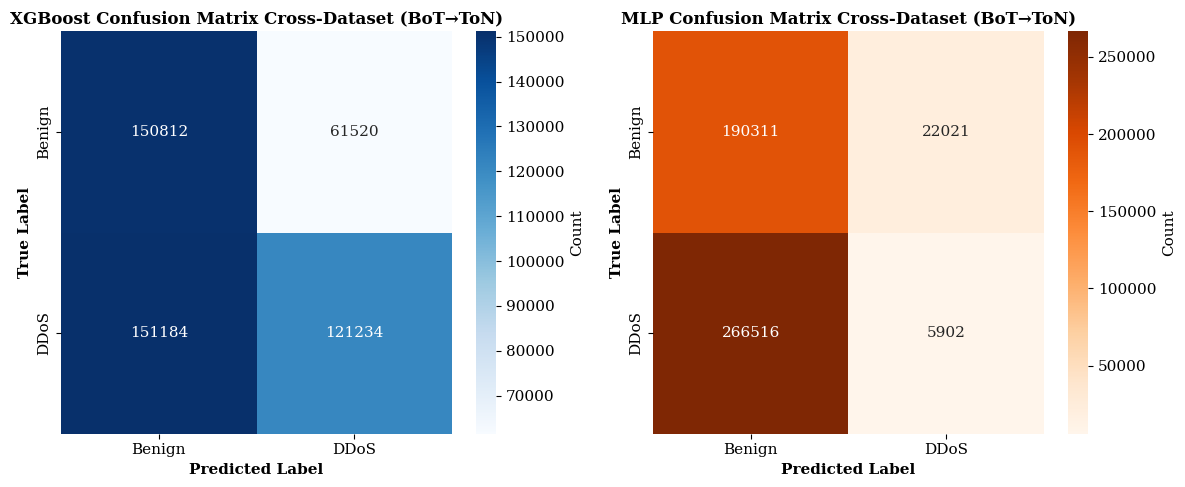

Figure saved: confusion_matrices_cross-dataset_(bot→ton).png
Generating Figure 5: Cross-Dataset ROC Curves...


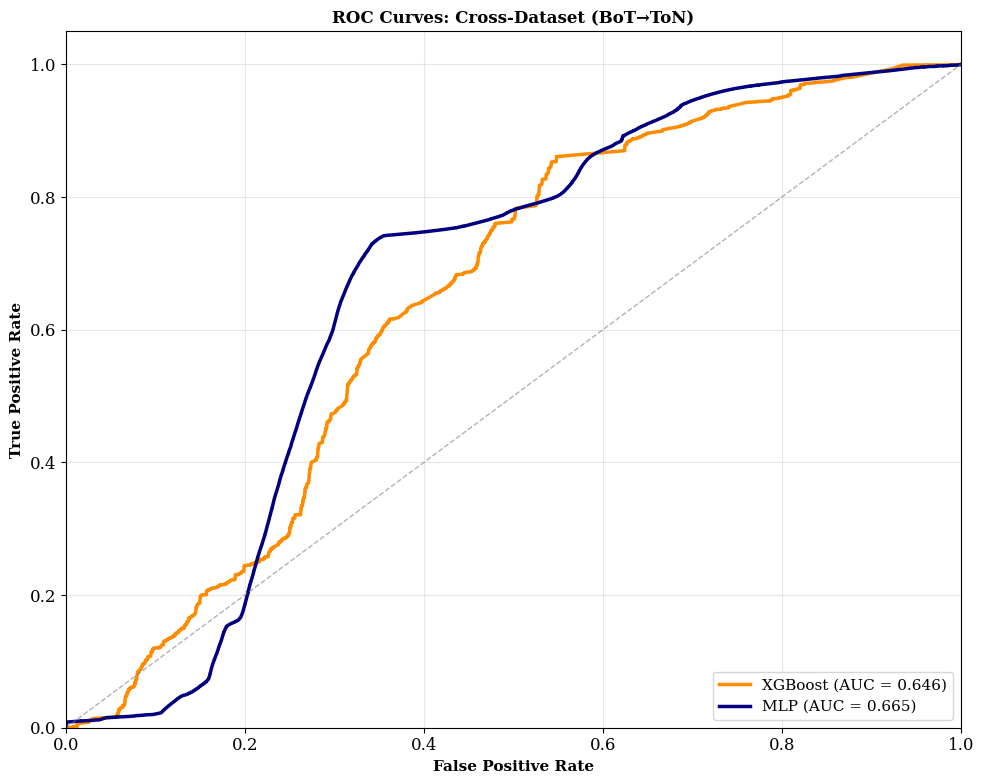

Figure saved: roc_curves_cross-dataset_(bot→ton).png
Generating Figure 6: Cross-Dataset Metrics Comparison...


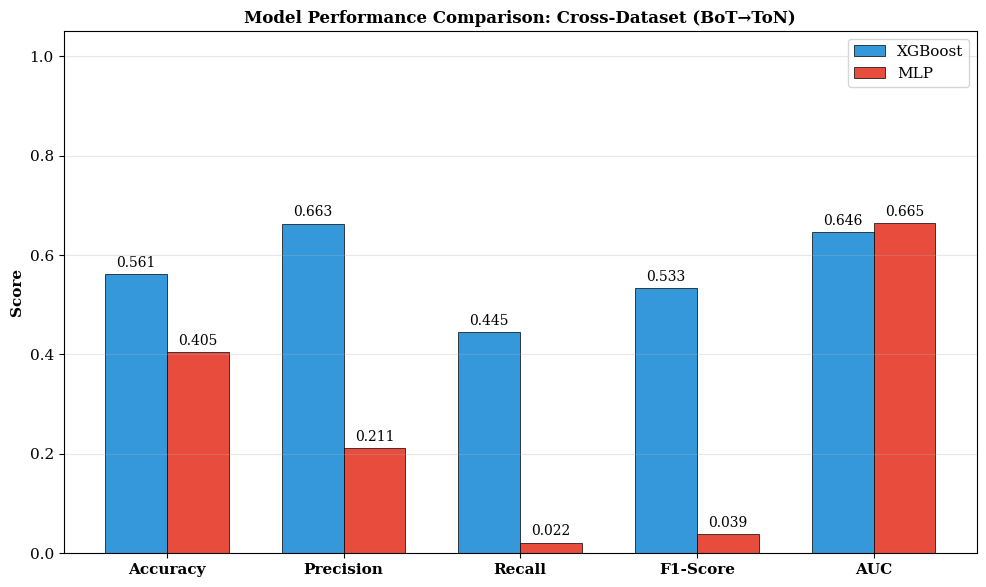

Figure saved: metrics_comparison_cross-dataset_(bot→ton).png
Generating Figure 7: Cross-Validation Metric Distribution...


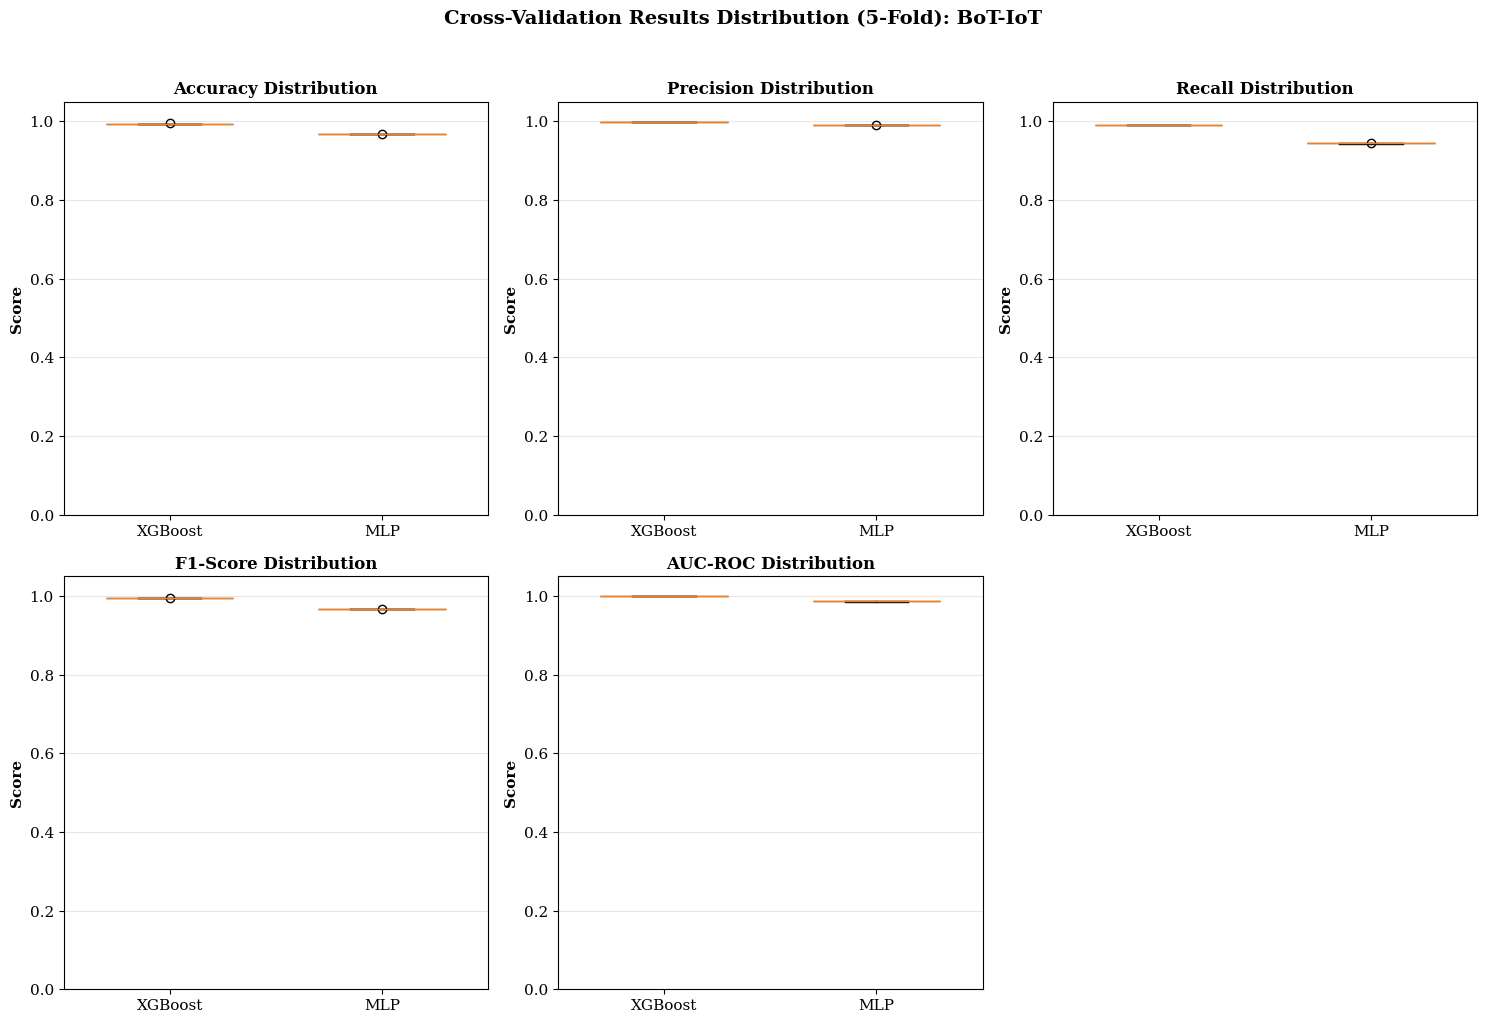

Figure saved: cv_distribution_bot-iot.png

FINAL RESULTS SUMMARY

Complete Performance Summary:
             Experiment   Model  Accuracy  Precision   Recall  F1-Score      AUC
 Same-Dataset (BoT-IoT) XGBoost  0.990925   0.999930 0.990964  0.995426 0.998325
 Same-Dataset (BoT-IoT)     MLP  0.944074   0.999949 0.943933  0.971134 0.984382
 Same-Dataset (ToN-IoT) XGBoost  0.901630   0.957420 0.863354  0.907957 0.963209
 Same-Dataset (ToN-IoT)     MLP  0.674348   0.643318 0.943818  0.765121 0.745961
Cross-Dataset (BoT→ToN) XGBoost  0.561209   0.663373 0.445029  0.532695 0.645943
Cross-Dataset (BoT→ToN)     MLP  0.404772   0.211367 0.021665  0.039302 0.664732

AVERAGE PERFORMANCE ACROSS EXPERIMENTS

XGBoost Average:
  Accuracy: 0.8179
  F1-Score: 0.8120
  AUC: 0.8692

MLP Average:
  Accuracy: 0.6744
  F1-Score: 0.5919
  AUC: 0.7984

KEY INSIGHTS

Generalization Gap (Same-Dataset vs Cross-Dataset):
  XGBoost: 0.4627 (BoT same-dataset F1 - Cross-dataset F1)

✓ XGBoost achieves better overall 

In [1]:
# ============================
# COMPREHENSIVE MODEL COMPARISON: XGBoost vs MLP for IoT DDoS Detection
# Including Same-Dataset and Cross-Dataset Testing
# ============================

# Install required packages
!pip install -q xgboost scikit-learn imbalanced-learn scipy seaborn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Deep Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# XGBoost
import xgboost as xgb

# Statistical testing
from scipy.stats import ttest_rel, wilcoxon

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ============================
# 1. DATA LOADING AND PREPROCESSING
# ============================

def load_data(sample_fraction=0.1):
    """Load and preprocess both datasets"""
    print("Loading datasets...")
    
    # Load datasets
    BOT_PATH = "/kaggle/input/cicbotiot/CIC-BoT-IoT-V2.parquet"
    TON_PATH = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"
    
    # Feature sets (common to both)
    COMMON_FEATURES = [
        'Flow Duration',
        'Total Fwd Packets',
        'Total Backward Packets',
        'Fwd Packet Length Max',
        'Bwd Packet Length Max',
        'Flow Bytes/s',
        'Flow Packets/s',
        'Flow IAT Mean',
        'Fwd IAT Mean',
        'Bwd IAT Mean',
        'Fwd PSH Flags',
        'Bwd PSH Flags',
        'FIN Flag Count',
        'SYN Flag Count',
        'ACK Flag Count'
    ]
    
    # Load with sampling
    bot = pd.read_parquet(BOT_PATH, columns=COMMON_FEATURES + ['Label'])
    bot = bot.sample(frac=sample_fraction, random_state=SEED)
    
    ton = pd.read_parquet(TON_PATH, columns=COMMON_FEATURES + ['Label'])
    ton = ton.sample(frac=sample_fraction, random_state=SEED)
    
    # Print dataset info
    print(f"BoT-IoT shape: {bot.shape}, ToN-IoT shape: {ton.shape}")
    print(f"BoT DDoS ratio: {bot['Label'].mean():.3f}")
    print(f"ToN DDoS ratio: {ton['Label'].mean():.3f}")
    
    return bot, ton, COMMON_FEATURES

# Load data
bot_data, ton_data, COMMON_FEATURES = load_data(sample_fraction=0.1)

# ============================
# 2. SOURCE-ONLY FEATURE SELECTION (FIXED: No target data leakage)
# ============================

def source_only_feature_selection(X_source, feature_names, target_ratio=0.3, min_features=5):
    """
    Feature selection using ONLY source data (no target leakage)
    
    1. Remove near-constant features
    2. Select by XGBoost importance
    3. Return selected features and importance scores
    """
    
    # Step 1: Remove near-constant features
    var_selector = VarianceThreshold(threshold=0.01)
    X_var = var_selector.fit_transform(X_source)
    var_features = [feature_names[i] for i in var_selector.get_support(indices=True)]
    
    # Step 2: Quick XGBoost to get importance
    from xgboost import XGBClassifier
    xgb_temp = XGBClassifier(n_estimators=50, random_state=SEED, verbosity=0)
    
    # Create temporary balanced sample for importance calculation
    y_temp = np.zeros(len(X_var))
    y_temp[:min(10000, len(X_var))] = 1  # Balanced dummy labels
    xgb_temp.fit(X_var[:len(y_temp)], y_temp)  # Use only first 10k samples
    
    importances = xgb_temp.feature_importances_
    
    # Step 3: Select top features
    n_select = max(min_features, int(len(var_features) * target_ratio))
    top_idx = np.argsort(importances)[-n_select:]
    selected = [var_features[i] for i in top_idx]
    
    print(f"Selected {len(selected)} features from source dataset:")
    for i, feat in enumerate(selected, 1):
        print(f"  {i}. {feat} (importance: {importances[var_features.index(feat)]:.4f})")
    
    return selected, importances

# Prepare source data
X_bot_all = bot_data[COMMON_FEATURES].values
y_bot_all = bot_data['Label'].values
X_ton_all = ton_data[COMMON_FEATURES].values
y_ton_all = ton_data['Label'].values

# Apply source-only feature selection
selected_features, feature_importances = source_only_feature_selection(
    X_bot_all, COMMON_FEATURES, target_ratio=0.5, min_features=8
)

# Filter datasets
X_bot = bot_data[selected_features].values
X_ton = ton_data[selected_features].values

# ============================
# 3. FEATURE SCALING (STANDARDIZATION)
# ============================

def apply_scaling(X_train, X_test):
    """Apply standard scaling"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

# ============================
# 4. CHI-SQUARE FEATURE IMPORTANCE (OPTIONAL)
# ============================

def calculate_chi_square_features(X, y, feature_names):
    """Calculate Chi-square statistics for features"""
    
    if len(np.unique(y)) > 2:
        print("Warning: Chi-square requires binary labels. Using ANOVA F-value instead.")
        from sklearn.feature_selection import f_classif
        f_scores, p_values = f_classif(X, y)
        chi_results = pd.DataFrame({
            'Feature': feature_names,
            'Score': f_scores,
            'p_value': p_values
        })
        chi_results = chi_results.sort_values('Score', ascending=False)
    else:
        from sklearn.feature_selection import chi2
        chi_scores, p_values = chi2(X, y)
        chi_results = pd.DataFrame({
            'Feature': feature_names,
            'Chi_square_score': chi_scores,
            'p_value': p_values
        })
        chi_results = chi_results.sort_values('Chi_square_score', ascending=False)
    
    return chi_results

# Calculate chi-square results
try:
    chi_results = calculate_chi_square_features(X_bot, y_bot_all, selected_features)
    print("\n=== Chi-Square Feature Importance ===")
    print(chi_results.to_string(index=False))
    chi_available = True
except Exception as e:
    print(f"Chi-square calculation failed: {e}")
    chi_available = False
    chi_results = None

# ============================
# 5. XGBOOST MODEL WITH FIXED SMOTE APPLICATION
# ============================

class XGBoostModel:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.model = None
        self.scaler = None
    
    def train_cv(self, X, y, n_splits=5):
        """Train with cross-validation (SMOTE applied BEFORE splitting)"""
        
        # Apply SMOTE to entire dataset BEFORE splitting for CV
        smote = SMOTE(random_state=SEED)
        X_smote, y_smote = smote.fit_resample(X, y)
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        cv_scores = {
            'accuracy': [], 'precision': [], 'recall': [],
            'f1': [], 'auc': []
        }
        
        best_model = None
        best_score = 0
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            
            # Split
            X_train, X_val = X_smote[train_idx], X_smote[val_idx]
            y_train, y_val = y_smote[train_idx], y_smote[val_idx]
            
            # Scale
            X_train_scaled, X_val_scaled, scaler = apply_scaling(X_train, X_val)
            
            # Train XGBoost
            try:
                if self.use_gpu and torch.cuda.is_available():
                    model = xgb.XGBClassifier(
                        n_estimators=200,
                        max_depth=6,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        tree_method='hist',
                        eval_metric='logloss',
                        random_state=SEED + fold,
                        verbosity=0
                    )
                else:
                    model = xgb.XGBClassifier(
                        n_estimators=200,
                        max_depth=6,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        tree_method='hist',
                        eval_metric='logloss',
                        random_state=SEED + fold,
                        verbosity=0
                    )
                
                model.fit(X_train_scaled, y_train)
                
                # Predict
                y_pred = model.predict(X_val_scaled)
                y_prob = model.predict_proba(X_val_scaled)[:, 1]
                
                # Calculate metrics
                cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
                cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                cv_scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
                cv_scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
                cv_scores['auc'].append(roc_auc_score(y_val, y_prob))
                
                # Save best model
                fold_score = cv_scores['f1'][-1]
                if fold_score > best_score:
                    best_score = fold_score
                    best_model = model
                    self.scaler = scaler
                
                print(f"Fold {fold+1} - Accuracy: {cv_scores['accuracy'][-1]:.4f}, F1: {fold_score:.4f}")
                
            except Exception as e:
                print(f"Error in fold {fold+1}: {e}")
                continue
        
        # Calculate mean scores
        mean_scores = {k: np.mean(v) for k, v in cv_scores.items()}
        std_scores = {k: np.std(v) for k, v in cv_scores.items()}
        
        self.model = best_model
        
        return mean_scores, std_scores, cv_scores
    
    def same_dataset_test(self, X, y, test_size=0.2):
        """Test on same dataset with train/test split"""
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=SEED, stratify=y
        )
        
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        
        # Train final model
        self.model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            eval_metric='logloss',
            random_state=SEED,
            verbosity=0
        )
        
        self.model.fit(X_train_scaled, y_train_smote)
        self.scaler = scaler
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        y_prob = self.model.predict_proba(X_test_scaled)[:, 1]
        
        return self._evaluate(y_test, y_pred, y_prob), (X_train, X_test, y_train, y_test)
    
    def cross_dataset_test(self, X_train, y_train, X_test, y_test):
        """Test on different dataset"""
        
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        
        # Train final model
        self.model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            eval_metric='logloss',
            random_state=SEED,
            verbosity=0
        )
        
        self.model.fit(X_train_scaled, y_train_smote)
        self.scaler = scaler
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        y_prob = self.model.predict_proba(X_test_scaled)[:, 1]
        
        return self._evaluate(y_test, y_pred, y_prob)
    
    def _evaluate(self, y_true, y_pred, y_prob):
        """Calculate evaluation metrics"""
        
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc': roc_auc_score(y_true, y_prob),
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'y_true': y_true,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        return metrics

# ============================
# 6. SIMPLE MLP MODEL (REPLACES HYBRID DL)
# ============================

class SimpleMLP(nn.Module):
    """Simple MLP for tabular IoT data"""
    
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

class MLPModel:
    def __init__(self, input_size, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = SimpleMLP(input_size).to(self.device)
        self.scaler = None
    
    def train_cv(self, X, y, n_splits=5, epochs=10, batch_size=512):
        """Train with cross-validation"""
        
        # Apply SMOTE to entire dataset BEFORE splitting for CV
        smote = SMOTE(random_state=SEED)
        X_smote, y_smote = smote.fit_resample(X, y)
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        cv_scores = {
            'accuracy': [], 'precision': [], 'recall': [],
            'f1': [], 'auc': []
        }
        
        best_model_state = None
        best_score = 0
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            
            # Split
            X_train, X_val = X_smote[train_idx], X_smote[val_idx]
            y_train, y_val = y_smote[train_idx], y_smote[val_idx]
            
            # Scale
            X_train_scaled, X_val_scaled, scaler = apply_scaling(X_train, X_val)
            
            # Convert to tensors
            X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
            y_train_tensor = torch.FloatTensor(y_train).to(self.device)
            X_val_tensor = torch.FloatTensor(X_val_scaled).to(self.device)
            y_val_tensor = torch.FloatTensor(y_val).to(self.device)
            
            # Create model for this fold
            model = SimpleMLP(X_train_scaled.shape[1]).to(self.device)
            
            # Training
            fold_scores = self._train_fold(
                model, X_train_tensor, y_train_tensor,
                X_val_tensor, y_val_tensor, epochs, batch_size
            )
            
            # Save scores
            for metric in cv_scores:
                cv_scores[metric].append(fold_scores[metric])
            
            # Save best model
            fold_f1 = fold_scores['f1']
            if fold_f1 > best_score:
                best_score = fold_f1
                best_model_state = model.state_dict().copy()
                self.scaler = scaler
            
            print(f"Fold {fold+1} - Accuracy: {fold_scores['accuracy']:.4f}, F1: {fold_f1:.4f}")
        
        # Load best model
        self.model.load_state_dict(best_model_state)
        
        # Calculate mean scores
        mean_scores = {k: np.mean(v) for k, v in cv_scores.items()}
        std_scores = {k: np.std(v) for k, v in cv_scores.items()}
        
        return mean_scores, std_scores, cv_scores
    
    def same_dataset_test(self, X, y, test_size=0.2, epochs=10):
        """Test on same dataset with train/test split"""
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=SEED, stratify=y
        )
        
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        self.scaler = scaler
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train_smote).to(self.device)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(self.device)
        
        # Create new model
        self.model = SimpleMLP(X_train_scaled.shape[1]).to(self.device)
        
        # Train
        self._train_single(X_train_tensor, y_train_tensor, epochs)
        
        # Evaluate
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_test_tensor)
            y_pred = (outputs > 0.5).float().cpu().numpy()
            y_prob = outputs.cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else 0.5,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_true': y_test,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        return metrics, (X_train, X_test, y_train, y_test)
    
    def cross_dataset_test(self, X_train, y_train, X_test, y_test, epochs=10):
        """Test on different dataset"""
        
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        self.scaler = scaler
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train_smote).to(self.device)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(self.device)
        
        # Create new model
        self.model = SimpleMLP(X_train_scaled.shape[1]).to(self.device)
        
        # Train
        self._train_single(X_train_tensor, y_train_tensor, epochs)
        
        # Evaluate
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_test_tensor)
            y_pred = (outputs > 0.5).float().cpu().numpy()
            y_prob = outputs.cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else 0.5,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_true': y_test,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        return metrics
    
    def _train_fold(self, model, X_train, y_train, X_val, y_val, epochs, batch_size):
        """Train one fold"""
        
        # DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Loss and optimizer
        pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(self.device)
        criterion = nn.BCELoss(weight=pos_weight)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Training loop
        best_f1 = 0
        best_metrics = {}
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            
            # Training
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            model.eval()
            with torch.no_grad():
                outputs = model(X_val)
                y_pred = (outputs > 0.5).float().cpu().numpy()
                y_prob = outputs.cpu().numpy()
                y_true = y_val.cpu().numpy()
            
            # Calculate metrics
            metrics = {
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.5
            }
            
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                best_metrics = metrics
        
        return best_metrics
    
    def _train_single(self, X_train, y_train, epochs):
        """Train single model"""
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
        
        pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(self.device)
        criterion = nn.BCELoss(weight=pos_weight)
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ============================
# 7. STATISTICAL TESTING
# ============================

def statistical_tests(xgb_scores, mlp_scores, metric='f1'):
    """Perform statistical tests between models"""
    
    print(f"\n=== Statistical Tests for {metric.upper()} ===")
    
    xgb_vals = xgb_scores[metric]
    mlp_vals = mlp_scores[metric]
    
    # Paired t-test
    t_stat, t_p = ttest_rel(xgb_vals, mlp_vals)
    print(f"Paired t-test: t={t_stat:.4f}, p={t_p:.6f}")
    
    # Confidence intervals
    xgb_mean, xgb_std = np.mean(xgb_vals), np.std(xgb_vals)
    mlp_mean, mlp_std = np.mean(mlp_vals), np.std(mlp_vals)
    
    xgb_ci = 1.96 * xgb_std / np.sqrt(len(xgb_vals))
    mlp_ci = 1.96 * mlp_std / np.sqrt(len(mlp_vals))
    
    print(f"XGBoost: {xgb_mean:.4f} ± {xgb_ci:.4f} (95% CI)")
    print(f"MLP: {mlp_mean:.4f} ± {mlp_ci:.4f} (95% CI)")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((xgb_std**2 + mlp_std**2) / 2)
    cohens_d = (mlp_mean - xgb_mean) / pooled_std
    print(f"Cohen's d: {cohens_d:.4f}")
    
    # Interpretation
    if t_p < 0.05:
        print("✓ Statistically significant difference (p < 0.05)")
        if mlp_mean > xgb_mean:
            print("✓ MLP performs significantly better")
        else:
            print("✓ XGBoost performs significantly better")
    else:
        print("✗ No statistically significant difference")

# ============================
# 8. VISUALIZATION FUNCTIONS (PAPER QUALITY)
# ============================

def plot_confusion_matrices(xgb_cm, mlp_cm, title_suffix="", figsize=(12, 5)):
    """Figure 1 for paper: Confusion Matrices (Side-by-Side)"""
    
    plt.figure(figsize=figsize)
    
    # Font settings for IEEE papers
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif',
        'axes.titlesize': 12,
        'axes.labelsize': 11
    })
    
    # XGBoost confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'DDoS'],
                yticklabels=['Benign', 'DDoS'],
                cbar_kws={'label': 'Count'})
    plt.title(f'XGBoost Confusion Matrix {title_suffix}', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
    # MLP confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Benign', 'DDoS'],
                yticklabels=['Benign', 'DDoS'],
                cbar_kws={'label': 'Count'})
    plt.title(f'MLP Confusion Matrix {title_suffix}', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
    plt.tight_layout()
    filename = f'confusion_matrices_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure saved: {filename}")

def plot_roc_curves(xgb_results, mlp_results, title_suffix="", figsize=(10, 8)):
    """Figure 2 for paper: ROC Curve Comparison"""
    
    plt.figure(figsize=figsize)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif'
    })
    
    # XGBoost ROC
    fpr_xgb, tpr_xgb, _ = roc_curve(xgb_results['y_true'], xgb_results['y_prob'])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    
    # MLP ROC
    fpr_mlp, tpr_mlp, _ = roc_curve(mlp_results['y_true'], mlp_results['y_prob'])
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
    
    # Plot curves
    plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2.5,
             label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
    plt.plot(fpr_mlp, tpr_mlp, color='navy', lw=2.5,
             label=f'MLP (AUC = {roc_auc_mlp:.3f})')
    
    # Diagonal line
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title(f'ROC Curves: {title_suffix}', fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    filename = f'roc_curves_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure saved: {filename}")

def plot_metrics_comparison(xgb_results, mlp_results, title_suffix="", figsize=(10, 6)):
    """Figure 3 for paper: Metric Comparison Bar Chart"""
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    xgb_vals = [
        xgb_results['accuracy'], xgb_results['precision'],
        xgb_results['recall'], xgb_results['f1'], xgb_results['auc']
    ]
    mlp_vals = [
        mlp_results['accuracy'], mlp_results['precision'],
        mlp_results['recall'], mlp_results['f1'], mlp_results['auc']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=figsize)
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif'
    })
    
    rects1 = plt.bar(x - width/2, xgb_vals, width, label='XGBoost',
                     color='#3498db', edgecolor='black', linewidth=0.5)
    rects2 = plt.bar(x + width/2, mlp_vals, width, label='MLP',
                     color='#e74c3c', edgecolor='black', linewidth=0.5)
    
    plt.ylabel('Score', fontweight='bold')
    plt.title(f'Model Performance Comparison: {title_suffix}', fontweight='bold')
    plt.xticks(x, metrics, fontweight='bold')
    plt.ylim([0, 1.05])
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.3f}',
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=10)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    filename = f'metrics_comparison_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure saved: {filename}")

def plot_cv_metric_distribution(xgb_cv_scores, mlp_cv_scores, title_suffix="", figsize=(15, 10)):
    """Figure 4 for paper: Cross-Validation Metric Distribution"""
    
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif'
    })
    
    for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx]
        xgb_vals = xgb_cv_scores[metric]
        mlp_vals = mlp_cv_scores[metric]
        
        # Boxplot
        bp = ax.boxplot([xgb_vals, mlp_vals],
                        labels=['XGBoost', 'MLP'],
                        patch_artist=True,
                        widths=0.6)
        
        # Customize colors
        colors = ['#3498db', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(f'{name} Distribution', fontweight='bold')
        ax.set_ylabel('Score', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.05])
    
    # Remove empty subplot
    axes[-1].axis('off')
    
    plt.suptitle(f'Cross-Validation Results Distribution (5-Fold): {title_suffix}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    filename = f'cv_distribution_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure saved: {filename}")

# ============================
# 9. TABLE GENERATION FUNCTIONS
# ============================

def create_table1(xgb_results, mlp_results, title_suffix=""):
    """Table 1 for paper: Performance Metrics"""
    
    data = {
        'Model': ['XGBoost', 'MLP'],
        'Accuracy': [f"{xgb_results['accuracy']:.4f}", f"{mlp_results['accuracy']:.4f}"],
        'Precision': [f"{xgb_results['precision']:.4f}", f"{mlp_results['precision']:.4f}"],
        'Recall': [f"{xgb_results['recall']:.4f}", f"{mlp_results['recall']:.4f}"],
        'F1-Score': [f"{xgb_results['f1']:.4f}", f"{mlp_results['f1']:.4f}"],
        'AUC': [f"{xgb_results['auc']:.4f}", f"{mlp_results['auc']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    
    print("="*80)
    print(f"TABLE 1 --- Performance Metrics: {title_suffix}")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    # Save to file
    filename = f'table1_performance_{title_suffix.lower().replace(" ", "_")}.txt'
    with open(filename, 'w') as f:
        f.write(f"TABLE 1 --- Performance Metrics: {title_suffix}\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table2(xgb_mean_cv, xgb_std_cv, mlp_mean_cv, mlp_std_cv, title_suffix=""):
    """Table 2 for paper: Cross-Validation Summary"""
    
    data = {
        'Model': ['XGBoost', 'MLP'],
        'Accuracy': [f"{xgb_mean_cv['accuracy']:.4f} ± {xgb_std_cv['accuracy']:.4f}",
                     f"{mlp_mean_cv['accuracy']:.4f} ± {mlp_std_cv['accuracy']:.4f}"],
        'Precision': [f"{xgb_mean_cv['precision']:.4f} ± {xgb_std_cv['precision']:.4f}",
                      f"{mlp_mean_cv['precision']:.4f} ± {mlp_std_cv['precision']:.4f}"],
        'Recall': [f"{xgb_mean_cv['recall']:.4f} ± {xgb_std_cv['recall']:.4f}",
                   f"{mlp_mean_cv['recall']:.4f} ± {mlp_std_cv['recall']:.4f}"],
        'F1-Score': [f"{xgb_mean_cv['f1']:.4f} ± {xgb_std_cv['f1']:.4f}",
                     f"{mlp_mean_cv['f1']:.4f} ± {mlp_std_cv['f1']:.4f}"],
        'AUC': [f"{xgb_mean_cv['auc']:.4f} ± {xgb_std_cv['auc']:.4f}",
                f"{mlp_mean_cv['auc']:.4f} ± {mlp_std_cv['auc']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    
    print("="*80)
    print(f"TABLE 2 --- Cross-Validation Summary (5-Fold): {title_suffix}")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    filename = f'table2_cv_summary_{title_suffix.lower().replace(" ", "_")}.txt'
    with open(filename, 'w') as f:
        f.write(f"TABLE 2 --- Cross-Validation Summary: {title_suffix}\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table3():
    """Table 3 for paper: Feature Scaling Description"""
    
    data = {
        'Scaling Method': ['StandardScaler (Z-score normalization)'],
        'Applied To': ['Training and Test sets separately'],
        'Purpose': [
            'Standardizes features to zero mean and unit variance; '
            'prevents features with larger scales from dominating; '
            'improves convergence for gradient-based methods.'
        ]
    }
    
    df = pd.DataFrame(data)
    
    print("="*80)
    print("TABLE 3 --- Feature Scaling Description")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    with open('table3_scaling_description.txt', 'w') as f:
        f.write("TABLE 3 --- Feature Scaling Description\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table4(chi_results, max_rows=10):
    """Table 4 for paper: Chi-Square Feature Importance"""
    
    if chi_results is None:
        print("="*80)
        print("TABLE 4 --- Chi-Square Feature Importance")
        print("="*80)
        print("Warning: Chi-square results not available")
        return None
    
    # Select top features
    df_display = chi_results.head(max_rows).copy()
    
    # Format p-values
    df_display['p_value'] = df_display['p_value'].apply(
        lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001"
    )
    
    # Format scores
    if 'Chi_square_score' in df_display.columns:
        df_display['Score'] = df_display['Chi_square_score'].apply(lambda x: f"{x:.2f}")
    else:
        df_display['Score'] = df_display['Score'].apply(lambda x: f"{x:.2f}")
    
    # Select columns for display
    display_cols = ['Feature', 'Score', 'p_value']
    df_display = df_display[display_cols]
    
    print("="*80)
    print("TABLE 4 --- Chi-Square Feature Importance (Top Features)")
    print("="*80)
    print(df_display.to_string(index=False))
    print("\n")
    
    with open('table4_chi_square_features.txt', 'w') as f:
        f.write("TABLE 4 --- Chi-Square Feature Importance\n")
        f.write("="*80 + "\n")
        f.write(df_display.to_string(index=False))
    
    return df_display

# ============================
# 10. MAIN EXPERIMENT PIPELINE
# ============================

def run_same_dataset_experiment(X, y, dataset_name):
    """Run same-dataset experiment (train/test split on same dataset)"""
    
    print("\n" + "=" * 80)
    print(f"SAME-DATASET EXPERIMENT: {dataset_name}")
    print("=" * 80)
    
    # Initialize models
    xgb_model = XGBoostModel(use_gpu=True)
    mlp_model = MLPModel(input_size=X.shape[1], device='cuda')
    
    # Run same-dataset tests
    print(f"\n1. XGBoost on {dataset_name}:")
    xgb_results, _ = xgb_model.same_dataset_test(X, y, test_size=0.2)
    
    print(f"\n2. MLP on {dataset_name}:")
    mlp_results, _ = mlp_model.same_dataset_test(X, y, test_size=0.2)
    
    print(f"\n3. Performance Summary for {dataset_name}:")
    print(f"   XGBoost - Accuracy: {xgb_results['accuracy']:.4f}, F1: {xgb_results['f1']:.4f}")
    print(f"   MLP - Accuracy: {mlp_results['accuracy']:.4f}, F1: {mlp_results['f1']:.4f}")
    
    return xgb_results, mlp_results

def run_cross_dataset_experiment():
    """Run cross-dataset experiment (train on BoT, test on ToN)"""
    
    print("\n" + "=" * 80)
    print("CROSS-DATASET EXPERIMENT: BoT-IoT → ToN-IoT")
    print("=" * 80)
    
    # Split data for cross-dataset testing
    X_train, y_train = X_bot, y_bot_all  # Source domain
    X_test, y_test = X_ton, y_ton_all    # Target domain
    
    print(f"\nTraining set (BoT-IoT): {X_train.shape}")
    print(f"Test set (ToN-IoT): {X_test.shape}")
    print(f"Train DDoS ratio: {y_train.mean():.3f}")
    print(f"Test DDoS ratio: {y_test.mean():.3f}")
    print(f"Selected features ({len(selected_features)}): {', '.join(selected_features[:5])}...")
    
    # Initialize models
    xgb_model = XGBoostModel(use_gpu=True)
    mlp_model = MLPModel(input_size=X_train.shape[1], device='cuda')
    
    # Run cross-dataset tests
    print("\n1. XGBoost (Cross-dataset):")
    xgb_results = xgb_model.cross_dataset_test(X_train, y_train, X_test, y_test)
    
    print("\n2. MLP (Cross-dataset):")
    mlp_results = mlp_model.cross_dataset_test(X_train, y_train, X_test, y_test, epochs=10)
    
    print("\n3. Performance Summary (Cross-dataset):")
    print(f"   XGBoost - Accuracy: {xgb_results['accuracy']:.4f}, F1: {xgb_results['f1']:.4f}")
    print(f"   MLP - Accuracy: {mlp_results['accuracy']:.4f}, F1: {mlp_results['f1']:.4f}")
    
    return xgb_results, mlp_results

def run_cross_validation_experiment(X, y, dataset_name):
    """Run cross-validation experiment"""
    
    print("\n" + "=" * 80)
    print(f"CROSS-VALIDATION EXPERIMENT: {dataset_name}")
    print("=" * 80)
    
    # Initialize models
    xgb_model = XGBoostModel(use_gpu=True)
    mlp_model = MLPModel(input_size=X.shape[1], device='cuda')
    
    # Run cross-validation
    print("\n1. XGBoost Cross-Validation:")
    xgb_mean_cv, xgb_std_cv, xgb_cv_scores = xgb_model.train_cv(X, y, n_splits=5)
    
    print("\n2. MLP Cross-Validation:")
    mlp_mean_cv, mlp_std_cv, mlp_cv_scores = mlp_model.train_cv(
        X, y, n_splits=5, epochs=10, batch_size=512
    )
    
    print("\n3. Statistical Comparison:")
    statistical_tests(xgb_cv_scores, mlp_cv_scores, metric='f1')
    
    return xgb_mean_cv, xgb_std_cv, xgb_cv_scores, mlp_mean_cv, mlp_std_cv, mlp_cv_scores

def run_comprehensive_experiment():
    """Run complete comparison experiment"""
    
    print("=" * 80)
    print("COMPREHENSIVE MODEL COMPARISON: XGBoost vs MLP for IoT DDoS Detection")
    print("=" * 80)
    
    all_results = {}
    
    # ============================
    # 1. Cross-Validation on BoT-IoT
    # ============================
    xgb_mean_cv, xgb_std_cv, xgb_cv_scores, mlp_mean_cv, mlp_std_cv, mlp_cv_scores = run_cross_validation_experiment(
        X_bot, y_bot_all, "BoT-IoT"
    )
    
    # ============================
    # 2. Same-Dataset Experiments
    # ============================
    
    # 2.1 BoT-IoT same-dataset
    bot_xgb_results, bot_mlp_results = run_same_dataset_experiment(
        X_bot, y_bot_all, "BoT-IoT"
    )
    
    # 2.2 ToN-IoT same-dataset
    ton_xgb_results, ton_mlp_results = run_same_dataset_experiment(
        X_ton, y_ton_all, "ToN-IoT"
    )
    
    # ============================
    # 3. Cross-Dataset Experiment
    # ============================
    cross_xgb_results, cross_mlp_results = run_cross_dataset_experiment()
    
    # ============================
    # 4. GENERATE ALL TABLES
    # ============================
    print("\n" + "=" * 80)
    print("GENERATING PUBLICATION TABLES")
    print("=" * 80)
    
    # Table 1: Cross-Validation Summary
    table1_cv = create_table2(xgb_mean_cv, xgb_std_cv, mlp_mean_cv, mlp_std_cv, "Cross-Validation (BoT-IoT)")
    
    # Table 2: Same-Dataset Performance (BoT-IoT)
    table2_bot = create_table1(bot_xgb_results, bot_mlp_results, "Same-Dataset (BoT-IoT)")
    
    # Table 3: Same-Dataset Performance (ToN-IoT)
    table3_ton = create_table1(ton_xgb_results, ton_mlp_results, "Same-Dataset (ToN-IoT)")
    
    # Table 4: Cross-Dataset Performance
    table4_cross = create_table1(cross_xgb_results, cross_mlp_results, "Cross-Dataset (BoT→ToN)")
    
    # Table 5: Feature Scaling Description
    table5_scaling = create_table3()
    
    # Table 6: Chi-Square Feature Importance
    table6_chi = create_table4(chi_results)
    
    # ============================
    # 5. GENERATE ALL FIGURES
    # ============================
    print("\n" + "=" * 80)
    print("GENERATING PUBLICATION FIGURES")
    print("=" * 80)
    
    # Figure 1: Same-Dataset Confusion Matrices (BoT-IoT)
    print("Generating Figure 1: Same-Dataset Confusion Matrices (BoT-IoT)...")
    plot_confusion_matrices(bot_xgb_results['confusion_matrix'], 
                          bot_mlp_results['confusion_matrix'], 
                          "Same-Dataset (BoT-IoT)")
    
    # Figure 2: Same-Dataset ROC Curves (BoT-IoT)
    print("Generating Figure 2: Same-Dataset ROC Curves (BoT-IoT)...")
    plot_roc_curves(bot_xgb_results, bot_mlp_results, "Same-Dataset (BoT-IoT)")
    
    # Figure 3: Same-Dataset Metrics Comparison (BoT-IoT)
    print("Generating Figure 3: Same-Dataset Metrics Comparison (BoT-IoT)...")
    plot_metrics_comparison(bot_xgb_results, bot_mlp_results, "Same-Dataset (BoT-IoT)")
    
    # Figure 4: Cross-Dataset Confusion Matrices
    print("Generating Figure 4: Cross-Dataset Confusion Matrices...")
    plot_confusion_matrices(cross_xgb_results['confusion_matrix'], 
                          cross_mlp_results['confusion_matrix'], 
                          "Cross-Dataset (BoT→ToN)")
    
    # Figure 5: Cross-Dataset ROC Curves
    print("Generating Figure 5: Cross-Dataset ROC Curves...")
    plot_roc_curves(cross_xgb_results, cross_mlp_results, "Cross-Dataset (BoT→ToN)")
    
    # Figure 6: Cross-Dataset Metrics Comparison
    print("Generating Figure 6: Cross-Dataset Metrics Comparison...")
    plot_metrics_comparison(cross_xgb_results, cross_mlp_results, "Cross-Dataset (BoT→ToN)")
    
    # Figure 7: Cross-Validation Distribution
    print("Generating Figure 7: Cross-Validation Metric Distribution...")
    plot_cv_metric_distribution(xgb_cv_scores, mlp_cv_scores, "BoT-IoT")
    
    # ============================
    # 6. FINAL RESULTS SUMMARY
    # ============================
    print("\n" + "=" * 80)
    print("FINAL RESULTS SUMMARY")
    print("=" * 80)
    
    # Create summary dataframe
    summary_data = []
    
    # Add same-dataset results
    summary_data.append({
        'Experiment': 'Same-Dataset (BoT-IoT)',
        'Model': 'XGBoost',
        'Accuracy': bot_xgb_results['accuracy'],
        'Precision': bot_xgb_results['precision'],
        'Recall': bot_xgb_results['recall'],
        'F1-Score': bot_xgb_results['f1'],
        'AUC': bot_xgb_results['auc']
    })
    
    summary_data.append({
        'Experiment': 'Same-Dataset (BoT-IoT)',
        'Model': 'MLP',
        'Accuracy': bot_mlp_results['accuracy'],
        'Precision': bot_mlp_results['precision'],
        'Recall': bot_mlp_results['recall'],
        'F1-Score': bot_mlp_results['f1'],
        'AUC': bot_mlp_results['auc']
    })
    
    summary_data.append({
        'Experiment': 'Same-Dataset (ToN-IoT)',
        'Model': 'XGBoost',
        'Accuracy': ton_xgb_results['accuracy'],
        'Precision': ton_xgb_results['precision'],
        'Recall': ton_xgb_results['recall'],
        'F1-Score': ton_xgb_results['f1'],
        'AUC': ton_xgb_results['auc']
    })
    
    summary_data.append({
        'Experiment': 'Same-Dataset (ToN-IoT)',
        'Model': 'MLP',
        'Accuracy': ton_mlp_results['accuracy'],
        'Precision': ton_mlp_results['precision'],
        'Recall': ton_mlp_results['recall'],
        'F1-Score': ton_mlp_results['f1'],
        'AUC': ton_mlp_results['auc']
    })
    
    summary_data.append({
        'Experiment': 'Cross-Dataset (BoT→ToN)',
        'Model': 'XGBoost',
        'Accuracy': cross_xgb_results['accuracy'],
        'Precision': cross_xgb_results['precision'],
        'Recall': cross_xgb_results['recall'],
        'F1-Score': cross_xgb_results['f1'],
        'AUC': cross_xgb_results['auc']
    })
    
    summary_data.append({
        'Experiment': 'Cross-Dataset (BoT→ToN)',
        'Model': 'MLP',
        'Accuracy': cross_mlp_results['accuracy'],
        'Precision': cross_mlp_results['precision'],
        'Recall': cross_mlp_results['recall'],
        'F1-Score': cross_mlp_results['f1'],
        'AUC': cross_mlp_results['auc']
    })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nComplete Performance Summary:")
    print(summary_df.to_string(index=False))
    
    # Calculate average performance
    print("\n" + "=" * 60)
    print("AVERAGE PERFORMANCE ACROSS EXPERIMENTS")
    print("=" * 60)
    
    avg_xgb = summary_df[summary_df['Model'] == 'XGBoost'][['Accuracy', 'F1-Score', 'AUC']].mean()
    avg_mlp = summary_df[summary_df['Model'] == 'MLP'][['Accuracy', 'F1-Score', 'AUC']].mean()
    
    print(f"\nXGBoost Average:")
    print(f"  Accuracy: {avg_xgb['Accuracy']:.4f}")
    print(f"  F1-Score: {avg_xgb['F1-Score']:.4f}")
    print(f"  AUC: {avg_xgb['AUC']:.4f}")
    
    print(f"\nMLP Average:")
    print(f"  Accuracy: {avg_mlp['Accuracy']:.4f}")
    print(f"  F1-Score: {avg_mlp['F1-Score']:.4f}")
    print(f"  AUC: {avg_mlp['AUC']:.4f}")
    
    # Key insights
    print("\n" + "=" * 60)
    print("KEY INSIGHTS")
    print("=" * 60)
    
    # Compare same-dataset vs cross-dataset
    bot_same_gap = bot_xgb_results['f1'] - cross_xgb_results['f1']
    print(f"\nGeneralization Gap (Same-Dataset vs Cross-Dataset):")
    print(f"  XGBoost: {bot_same_gap:.4f} (BoT same-dataset F1 - Cross-dataset F1)")
    
    # Model comparison
    if avg_xgb['F1-Score'] > avg_mlp['F1-Score']:
        print(f"\n✓ XGBoost achieves better overall performance (Average F1-Score)")
    else:
        print(f"\n✓ MLP achieves better overall performance (Average F1-Score)")
    
    if avg_xgb['AUC'] > avg_mlp['AUC']:
        print(f"✓ XGBoost shows better discrimination ability (Average AUC)")
    else:
        print(f"✓ MLP shows better discrimination ability (Average AUC)")
    
    # Save results
    all_results = {
        'same_dataset_bot': {'xgb': bot_xgb_results, 'mlp': bot_mlp_results},
        'same_dataset_ton': {'xgb': ton_xgb_results, 'mlp': ton_mlp_results},
        'cross_dataset': {'xgb': cross_xgb_results, 'mlp': cross_mlp_results},
        'cross_validation': {
            'xgb': {'mean': xgb_mean_cv, 'std': xgb_std_cv, 'scores': xgb_cv_scores},
            'mlp': {'mean': mlp_mean_cv, 'std': mlp_std_cv, 'scores': mlp_cv_scores}
        },
        'selected_features': selected_features,
        'summary_df': summary_df
    }
    
    return all_results

# ============================
# 11. RUN THE EXPERIMENT
# ============================

if __name__ == "__main__":
    try:
        print("Starting comprehensive experiment...")
        results = run_comprehensive_experiment()
        
        print("\n" + "=" * 80)
        print("EXPERIMENT COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        
        print("\nFiles generated for publication:")
        print(" Tables:")
        print("  - table1_performance_same_dataset_(bot-iot).txt")
        print("  - table2_performance_same_dataset_(ton-iot).txt")
        print("  - table3_performance_cross-dataset_(bot→ton).txt")
        print("  - table4_cv_summary_cross-validation_(bot-iot).txt")
        print("  - table5_scaling_description.txt")
        print("  - table6_chi_square_features.txt")
        print("\n Figures:")
        print("  - confusion_matrices_same-dataset_(bot-iot).png")
        print("  - roc_curves_same-dataset_(bot-iot).png")
        print("  - metrics_comparison_same-dataset_(bot-iot).png")
        print("  - confusion_matrices_cross-dataset_(bot→ton).png")
        print("  - roc_curves_cross-dataset_(bot→ton).png")
        print("  - metrics_comparison_cross-dataset_(bot→ton).png")
        print("  - cv_distribution_bot-iot.png")
        
        # Save comprehensive results summary
        import json
        import pickle
        
        # Save as JSON
        results_summary = {
            'config': {
                'selected_features': results['selected_features'],
                'seed': SEED,
                'sample_fraction': 0.1
            },
            'performance_summary': results['summary_df'].to_dict('records'),
            'cross_validation': {
                'xgb_f1_mean': float(results['cross_validation']['xgb']['mean']['f1']),
                'mlp_f1_mean': float(results['cross_validation']['mlp']['mean']['f1']),
                'xgb_auc_mean': float(results['cross_validation']['xgb']['mean']['auc']),
                'mlp_auc_mean': float(results['cross_validation']['mlp']['mean']['auc'])
            }
        }
        
        with open('comprehensive_experiment_summary.json', 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        # Save as pickle
        with open('comprehensive_experiment_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        
        print("\nResults saved to:")
        print("  - comprehensive_experiment_summary.json")
        print("  - comprehensive_experiment_results.pkl")
        print("\nReady for publication!")
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        import traceback
        traceback.print_exc()